In [ ]:
import sys
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Any


# Used in order to get around not being able to use ".." for imports
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from core.LangevinGillespie import LangevinGillespie
from utils.compute_transition_matrix import compute_transition_matrix


# add the compiled-extension directory (absolute) so `import f1sim` works
module_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "core", "cpp_extensions", "cpp"))
if module_dir not in sys.path:
    sys.path.insert(0, module_dir)

from f1sim import LangevinGillespie as LangevinGillespi_PybindWrap


In [2]:
# Simulation Setup
LG = LangevinGillespie()
LG.steps = 2000
LG.dt = 1e-6
LG.method = "heun"

# Mechanical / Thermal Setup
LG.kappa = 56
LG.kBT = 4.14
LG.gammaB = LG.computeGammaB(a=20, r=19, eta=1e-9)

# Multi State Setup
LG.theta_states = np.array([3, 36, 72, 116]) * math.pi / 180  # Deg → Rad
LG.initial_state = 0  # Starting state

# Transition rate matrix
LG.transition_matrix = compute_transition_matrix(LG)

In [16]:
def compute_simulation_time(obj: Any, n_steps: int, rng_seed: Any = None) -> float:
    """Run a simulation with n_steps on `obj` and return elapsed time in seconds."""
    obj.steps = n_steps
    start_time = time.time()
    # pass rng_seed positionally so it works for both the Python LG (rng) and the C++ wrap (seed)
    obj.simulate(rng_seed)
    return time.time() - start_time


MAX_STEPS = 100000
STEP_INTERVAL = 1

In [ ]:
step_counts = list(range(1, MAX_STEPS + 1, STEP_INTERVAL))
times = []

print("Running simulations...")
for steps in step_counts:
    elapsed = compute_simulation_time(LG, steps, rng_seed=42)
    times.append(elapsed)

In [ ]:
average_time = np.mean(times)
print(f"\nAverage simulation time: {average_time:.4f} seconds")
x = np.array(step_counts)
y = np.array(times)

# moving average
window = 11
smooth = np.convolve(y, np.ones(window)/window, mode="same")

plt.figure(figsize=(8,4))
plt.plot(x, y, alpha=0.4, label="raw")
plt.plot(x, smooth, lw=2, label=f"{window}-pt MA")
plt.xlabel("Number of steps")
plt.ylabel("Elapsed time (s)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
t_per_step = np.array(times) / np.array(step_counts)
plt.figure(figsize=(8,4))
plt.plot(step_counts, t_per_step * 1e6, marker=".", linestyle="-")
plt.xlabel("Number of steps")
plt.ylabel("Time per step (µs)")
plt.title("Per-step latency")
plt.grid(True)
plt.show()

In [ ]:
# Simulation Setup
LG2 = LangevinGillespi_PybindWrap()
LG2.steps = 2000
LG2.dt = 1e-6
LG2.method = "heun"

# Mechanical / Thermal Setup
LG2.kappa = 56
LG2.kBT = 4.14
LG2.gammaB = LG2.computeGammaB(a=20, r=19, eta=1e-9)

# Multi State Setup
LG2.theta_states = np.array([3, 36, 72, 116]) * math.pi / 180  # Deg → Rad
LG2.initial_state = 0  # Starting state

# Transition rate matrix
LG2.transition_matrix = compute_transition_matrix(LG2)

In [17]:
step_counts = list(range(1, MAX_STEPS + 1, STEP_INTERVAL))
times = []

print("Running simulations...")
for steps in step_counts:
    elapsed = compute_simulation_time(LG2, steps, rng_seed=42)
    times.append(elapsed)

Running simulations...



Average simulation time: 0.0047 seconds


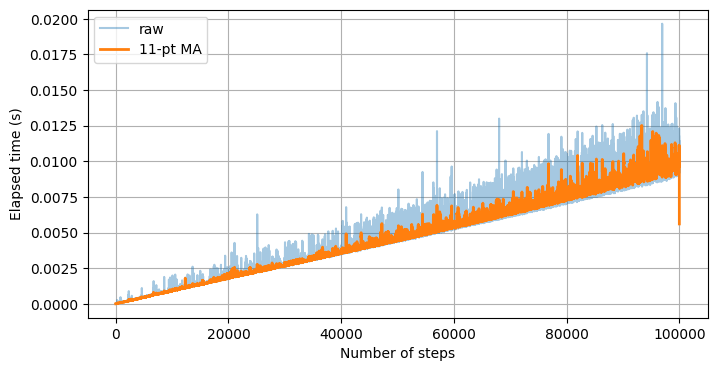

In [23]:
average_time = np.mean(times)
print(f"\nAverage simulation time: {average_time:.4f} seconds")
x = np.array(step_counts)
y = np.array(times)

# moving average
window = 11
smooth = np.convolve(y, np.ones(window)/window, mode="same")

plt.figure(figsize=(8,4))
plt.plot(x, y, alpha=0.4, label="raw")
plt.plot(x, smooth, lw=2, label=f"{window}-pt MA")
plt.xlabel("Number of steps")
plt.ylabel("Elapsed time (s)")
plt.legend()
plt.grid(True)
plt.show()

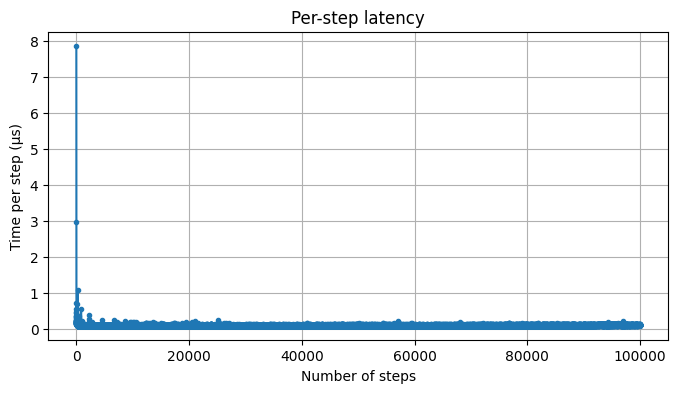

In [19]:
t_per_step = np.array(times) / np.array(step_counts)
plt.figure(figsize=(8,4))
plt.plot(step_counts, t_per_step * 1e6, marker=".", linestyle="-")
plt.xlabel("Number of steps")
plt.ylabel("Time per step (µs)")
plt.title("Per-step latency")
plt.grid(True)
plt.show()


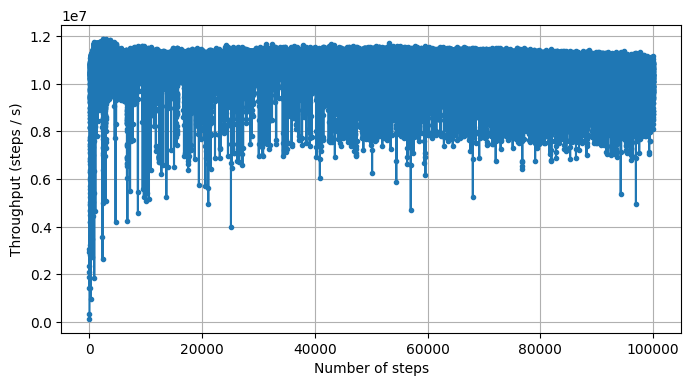

In [20]:
throughput = np.array(step_counts) / np.array(times)  # steps / s
plt.figure(figsize=(8,4))
plt.plot(step_counts, throughput, marker=".", linestyle="-")
plt.xlabel("Number of steps")
plt.ylabel("Throughput (steps / s)")
plt.grid(True)
plt.show()


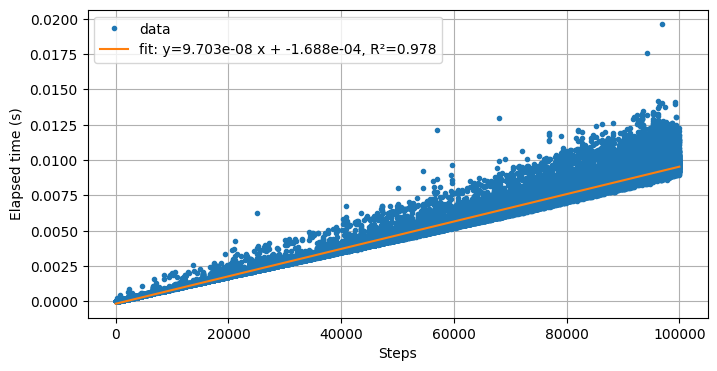

In [21]:
# linear fit
x = np.array(step_counts)
y = np.array(times)
coef = np.polyfit(x, y, 1)   # degree 1 fit
pred = np.poly1d(coef)(x)
ss_res = np.sum((y - pred)**2)
ss_tot = np.sum((y - y.mean())**2)
r2 = 1 - ss_res/ss_tot

plt.figure(figsize=(8,4))
plt.plot(x, y, ".", label="data")
plt.plot(x, pred, "-", label=f"fit: y={coef[0]:.3e} x + {coef[1]:.3e}, R²={r2:.3f}")
plt.xlabel("Steps")
plt.ylabel("Elapsed time (s)")
plt.legend()
plt.grid(True)
plt.show()
